<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
!rm -rf geological_similarity

**Importar arquivos de configuração do Kaglle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


###  Download dos dados / descompactando os dados

In [6]:
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq  geological-image-similarity

 74% 25.0M/33.6M [00:01<00:00, 16.3MB/s]
100% 33.6M/33.6M [00:01<00:00, 33.0MB/s]


In [ ]:
#!kaggle datasets download fabiobasson/geological-similarity
#! unzip -qq  geological-similarity

geological-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#! rm -rf gneiss andesite

### Data Preprocessing

In [7]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir = glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


In [8]:
andesite_dir[0:4]

['geological_similarity/andesite/9FUK8.jpg',
 'geological_similarity/andesite/20XR8.jpg',
 'geological_similarity/andesite/PT0WZ.jpg',
 'geological_similarity/andesite/Z7KXW.jpg']

In [ ]:
#geological_similarity = 'geological_similarity'
#subfolders = [f.path for f in os.scandir(geological_similarity) if f.is_dir()]


In [9]:
class_names = ['andesite', 'gneiss', 'marbler', 'quartzite', 'rhyolite','schist']
class_names[0]

'andesite'

In [11]:
andesite_df=[];gneiss_df=[];marble_df=[]
quartzite_df=[]
rhyolite_df=[]
schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,class_names[0]])
for j in gneiss_dir:
   gneiss_df.append([j,class_names[1]])
for l in marble_dir:
    marble_df.append([l,class_names[2]])
for m in quartzite_dir:
    quartzite_df.append([m,class_names[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,class_names[4]])
for o in schist_dir:
    schist_df.append([o,class_names[5]])
   
df = andesite_df + gneiss_df + marble_df + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
df

[['geological_similarity/quartzite/IBW6D.jpg', 'quartzite'],
 ['geological_similarity/rhyolite/GL668.jpg', 'rhyolite'],
 ['geological_similarity/rhyolite/KX911.jpg', 'rhyolite'],
 ['geological_similarity/gneiss/DFXR0.jpg', 'gneiss'],
 ['geological_similarity/gneiss/P4PUG.jpg', 'gneiss'],
 ['geological_similarity/gneiss/QTZPB.jpg', 'gneiss'],
 ['geological_similarity/andesite/E1D4M.jpg', 'andesite'],
 ['geological_similarity/quartzite/H3NWH.jpg', 'quartzite'],
 ['geological_similarity/marble/FBCR1.jpg', 'marbler'],
 ['geological_similarity/andesite/NY8T1.jpg', 'andesite'],
 ['geological_similarity/andesite/H9U1E.jpg', 'andesite'],
 ['geological_similarity/gneiss/T41Z5.jpg', 'gneiss'],
 ['geological_similarity/gneiss/L0PPO.jpg', 'gneiss'],
 ['geological_similarity/marble/U85JV.jpg', 'marbler'],
 ['geological_similarity/rhyolite/DVST0.jpg', 'rhyolite'],
 ['geological_similarity/marble/L0YXT.jpg', 'marbler'],
 ['geological_similarity/marble/N438T.jpg', 'marbler'],
 ['geological_similarity/

In [13]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/quartzite/IBW6D.jpg,quartzite
1,geological_similarity/rhyolite/GL668.jpg,rhyolite
2,geological_similarity/rhyolite/KX911.jpg,rhyolite
3,geological_similarity/gneiss/DFXR0.jpg,gneiss
4,geological_similarity/gneiss/P4PUG.jpg,gneiss
...,...,...
24993,geological_similarity/gneiss/CIIZY.jpg,gneiss
24994,geological_similarity/marble/O2XXH.jpg,marbler
24995,geological_similarity/andesite/B7506.jpg,andesite
24996,geological_similarity/rhyolite/G4CSX.jpg,rhyolite


## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [20]:
IMG_SHAPE = 28
BATCH_SIZE = 20

In [18]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split=0.2)

In [24]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(28,28),
                                              #class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(28,28),
                                                   #class_mode='binary',
                                                   subset='validation')

Found 19999 validated image filenames belonging to 5 classes.
Found 4999 validated image filenames belonging to 5 classes.


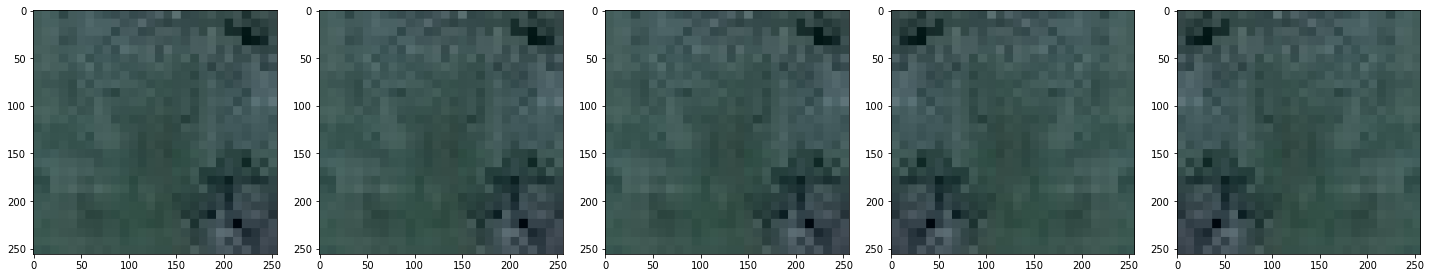

In [25]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)